Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Letícia da Silva Macedo Alves"
COLLABORATORS = ""

---

# Lista 08 - Comparando Classificadores

# Exercício 01:

Analise o desempenho do kNN e de uma Regressão Logística Regularizada para **pelo menos um** dos conjuntos de dados abaixo:

* [Avaliação de carros](http://archive.ics.uci.edu/ml/datasets/Car+Evaluation)
* [Avaliação de vinhos](http://archive.ics.uci.edu/ml/datasets/Wine+Quality)
* [Resultados de partidas do jogo Dota](http://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results) (desafiador!)

Para a questão, faça as seguintes tarefas:

* Realize treino, validação e teste
* Compare as métricas no teste
* Reporte a precisão, revocação, F1 e a matriz de confusão

Como já estamos no fim da matéria, você pode agora fazer uso da biblioteca scikit-learn. Afinal, no dia a dia, não implementamos tudo do zero. Abaixo temos os imports que vocês precisam. Leiam a API da biblioteca para saber como fazer uso da mesma.

In [2]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn.neighbors import KNeighborsClassifier

# Um fator importante é que o SKLearn não cria conjuntos de validação para você. Você tem algumas abordagens,
# uma é realizar um novo split no treino. Outra é fazer uso de classificadores com CV no fim.
# Tipo LogisticRegressionCV (ver na API). Por fim, você pode fazer uso da classe GridSearchCV.
# Leia a documentação da mesma.
from sklearn.model_selection import train_test_split

In [3]:
# YOUR CODE HERE
#Imports e configurações padrão
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

plt.ion()
plt.style.use('seaborn-colorblind')

Primeiramente, começamos lendo nossos dados. O banco escolhido é o de "Avaliação de Vinhos Vermelhos" ("Red Wine Quality").
Uma visão geral dos dados é apresentada abaixo. Temos 1599 linhas e 12 colunas.

In [4]:
df = pd.read_csv('./winequality-red.csv', sep = ";")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Chamaremos de y os valores de classificação que queremos prever (coluna "quality") e X a variável que contém os atributos (as demais colunas). Os vinhos são classificados, por sua qualidade, em um valor inteiro entre 0 e 10, que são as classes das nossas respostas categóricas. Logo, temos um caso de classificação multiclasse.

In [5]:
X = df.copy()
X = X.drop('quality', axis=1)
y = df['quality']

Separemos agora os conjuntos de Treino e Teste. 

In [6]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2)

Todos os dados dos atributos são numéricos. Logo, precisamos normalizar todas as colunas de X. Isto é, vamos agora Z-normalizar o conjunto de Treino e Teste. Vale lembrar que devemos usar sempre a média e desvio do TREINO para a normalização, já que o conjunto de treino é o que conhecemos e nosso Teste é o futuro, o que ainda não conhecemos e queremos prever.

In [7]:
media_treino = X_treino.mean()
desvio_treino = X_treino.std(ddof=1)

Z_treino = X_treino.copy()
Z_treino = (Z_treino - media_treino)/desvio_treino

Z_teste = X_teste.copy()
Z_teste = (Z_teste - media_treino)/desvio_treino

#Z_treino.describe()
#Z_teste.describe()

KNN

Vamos utilizar o classificador KNN para estimar a qualidade de vinhos. Queremos achar o classificador com a melhor Acurácia. Isto é, quero o melhor parâmetro k que é, na média, o melhor valor para as execuções. Devemos então treinar o conjunto de treino e avaliar as previsões no conjunto de validação para encontrar o k com os melhores resultados.

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

#fold = 0

skf = StratifiedKFold(n_splits=5, shuffle=True)
melhores = []

for treino_indice, validacao_indice in skf.split(Z_treino, y_treino):
    melhor = (0, 0)
    
    for k in range (1,26):
        modelo = KNeighborsClassifier(n_neighbors=k)
        modelo.fit(Z_treino.values[treino_indice], y_treino.values[treino_indice])
        
        y_real = y_treino.values[validacao_indice]
        y_prev = modelo.predict(Z_treino.values[validacao_indice])
        
        acuracia = accuracy_score(y_real, y_prev)
        
        if (acuracia > melhor[0]):
            melhor = (acuracia, k)
    
    melhores.append(melhor[1])
    
    #fold += 1
    #print('Fold-{}, melhor n = {}, acc = {}'.format(fold, melhor[1], melhor[0]))

print(melhores)

[1, 1, 1, 13, 1]


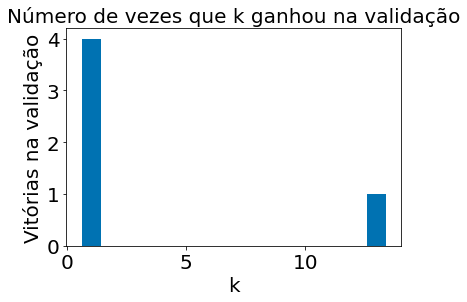

In [9]:
unique, counts = np.unique(melhores, return_counts=True)
plt.bar(unique, counts)

plt.title('Número de vezes que k ganhou na validação')
plt.xlabel('k')
plt.ylabel('Vitórias na validação')

plt.show()

Vemos então que k=1 parece ser o melhor. Vamos agora avaliar o modelo no conjunto de teste usando k=1 e verificar as métricas das classes. 

In [10]:
from sklearn.metrics import classification_report

modelo_knn = KNeighborsClassifier(n_neighbors=1)
modelo_knn.fit(Z_treino, y_treino)

print(classification_report(y_teste, modelo_knn.predict(Z_teste), zero_division=0))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.25      0.15      0.19        13
           5       0.65      0.63      0.64       129
           6       0.59      0.66      0.62       132
           7       0.57      0.51      0.54        41
           8       0.50      0.33      0.40         3

    accuracy                           0.60       320
   macro avg       0.43      0.38      0.40       320
weighted avg       0.59      0.60      0.59       320



Vemos então que erramos muito na previsão da classe 3, 4 e 8. Podemos visualizar isso melhor através da matriz de confusão abaixo.

In [11]:
print(confusion_matrix(y_teste, modelo_knn.predict(Z_teste)))

[[ 0  0  1  1  0  0]
 [ 1  2  5  5  0  0]
 [ 0  2 81 40  6  0]
 [ 0  3 33 87  9  0]
 [ 0  1  4 14 21  1]
 [ 0  0  0  1  1  1]]


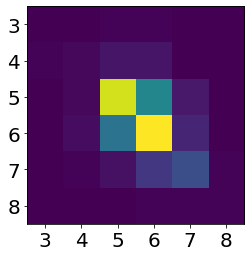

In [12]:
plt.imshow(confusion_matrix(y_teste, modelo_knn.predict(Z_teste)))
plt.xticks(np.arange(6), ("3", "4", "5", "6", "7", "8"))
plt.yticks(np.arange(6), ("3", "4", "5", "6", "7", "8"))

plt.show()

REGRESSÃO LOGÍSTICA

Vamos agora utilizar uma Regressão Logística para treinar e validar nossos dados para a previsão da qualidade de vinhos. A função utilizada para isso foi utilizada pelo professor no notebook da aula 23 e já possui Validação Cruzada e regularização internas.

In [13]:
from sklearn.linear_model import LogisticRegressionCV

modelo_rl = LogisticRegressionCV(Cs=100, penalty='l2', cv=5, fit_intercept=False, multi_class='ovr')
modelo_rl.fit(Z_treino, y_treino)

LogisticRegressionCV(Cs=100, cv=5, fit_intercept=False, multi_class='ovr')

Podemos verificar as métricas das classes abaixo.

In [15]:
print(classification_report(y_teste, modelo_rl.predict(Z_teste), zero_division=0))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        13
           5       0.63      0.77      0.69       129
           6       0.46      0.13      0.20       132
           7       0.30      0.83      0.44        41
           8       0.00      0.00      0.00         3

    accuracy                           0.47       320
   macro avg       0.23      0.29      0.22       320
weighted avg       0.48      0.47      0.42       320



Novamente vemos que erramos majoritariamente na previsão da classe 3, 4 e 8.

In [16]:
print(confusion_matrix(y_teste, modelo_rl.predict(Z_teste)))

[[ 0  0  2  0  0  0]
 [ 3  0  5  2  3  0]
 [ 3  0 99 13 14  0]
 [ 4  0 49 17 61  1]
 [ 0  0  2  5 34  0]
 [ 0  0  0  0  3  0]]


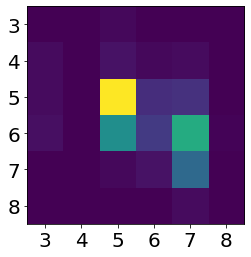

In [17]:
plt.imshow(confusion_matrix(y_teste, modelo_rl.predict(Z_teste)))
plt.xticks(np.arange(6), ("3", "4", "5", "6", "7", "8"))
plt.yticks(np.arange(6), ("3", "4", "5", "6", "7", "8"))

plt.show()

Explique e discuta sobre os resultados encontrados no campo abaixo.

Usando KNN obtivemos melhor acurácia. Pudemos então observar pelos resultados que, para a base de dados escolhida, o classificador KNN obteve melhor desempenho se comparado à Regressão Logística. Acho que isso se deve ao fato da previsão ser um caso de classificação multiclasse. Assim, faz sentido que, se as características de um vinho são parecidas com a de seus vizinhos mais próximo, ele provavelmente receberá a mesma classificação de qualidade.